# Density of dispersoids by constituent particles

Håkon Wiik Ånes (hakon.w.anes@ntnu.no), 2022-11-29, Norwegian University of Science and Technology (NTNU)

This notebook as a *Python* script accepting parameters is also available under the same file name.

Procedure:
1. Get label map for particles
2. Expand label map using `skimage.segmentation.expand_labels()`, which uses `scipy.ndimage.distance_transform_edt()`
3. Get masks of region inside precipitate-free zones (PFZs), excluding big particles, and outside
4. Calculate:
    1. Density of particles inside and outside PFZs
    2. Area weighted particle size inside and outside PFZs

In [2]:
# Use the qt5 backend for interactive plotting (from the pyqt package)
%matplotlib inline

from datetime import date
import importlib_metadata
from pathlib import Path
import re

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.color as skc
from skimage.measure import label
from skimage.segmentation import expand_labels

from mapregions import MapRegions


print("Run date: ", date.today())
print("\nSoftware versions\n-----------------")
for pkg in ["mapregions", "matplotlib", "numpy", "pandas", "scikit-image"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-11-29

Software versions
-----------------
mapregions : 0.1.dev0
matplotlib : 3.6.2
numpy : 1.23.5
pandas : 1.5.2
scikit-image : 0.19.3


In [3]:
bse_step_size = 1 / 39.2
titles = ["Def.", r"175 $^{\circ}$C", r"300 $^{\circ}$C", r"325 $^{\circ}$C"]
identifier = ["0s", "175c", "300c", "325c"]

## Densities and sizes per dataset

Set input parameters

In [11]:
to_plot = True

# Dataset
sample = "175c"
dset = 1

# Particle size thresholds in um for constituent particles (PSN) and
# dispersoids (Smith-Zener drag)
constituent_threshold = 0.8
dispersoid_threshold_max = 0.24  # um
dispersoid_threshold_min = 0.03  # um

# Extent of PFZ out from constituent particles in um
pfz_extent = 2
pfz_extent_px = int(np.ceil(pfz_extent * bse_step_size * 1e3))

Load data

In [12]:
dir_data = Path("/home/hakon/phd/data/p/prover") / sample / str(dset) / "partdet"
img = np.load(dir_data / "bse_labels_filled_filtered.npy")

Get label map of particles

In [13]:
seg1 = label(img)
mreg = MapRegions(seg1, dx=bse_step_size, dy=bse_step_size, background_label=0, scan_unit="um")

Get big particles

In [14]:
mask_big = 0.816 * 2 * mreg.equivalent_radius >= constituent_threshold

mreg_big = mreg[mask_big]
mreg_big

MapRegions: 82

Extend label map of big particles

In [15]:
seg2 = expand_labels(mreg_big.label_map, distance=pfz_extent_px)
mask = seg2 > 0

Mask and area of precipitate-free zones (PFZs)

In [16]:
pfz = mask.astype(int) - (~mreg_big.is_background_map).astype(int)
pfz = pfz.astype(bool)
area_pfz = np.sum(pfz) * bse_step_size ** 2

Mask and area of pixels outside PFZs (excluding constituent particles themselves)

In [17]:
not_pfz = ~pfz
not_pfz[~mreg_big.is_background_map] = False
area_not_pfz = np.sum(not_pfz) * bse_step_size ** 2

Sanity checks (raise assertion error(s) if false)

In [18]:
# Mask sizes
assert np.sum([pfz, not_pfz, ~mreg_big.is_background_map]) == img.size

# Areas
assert np.allclose(
    np.sum([area_pfz, area_not_pfz, np.sum(~mreg_big.is_background_map) * bse_step_size ** 2]),
    img.size * bse_step_size ** 2,
    atol=1e-5
)

Plot all maps

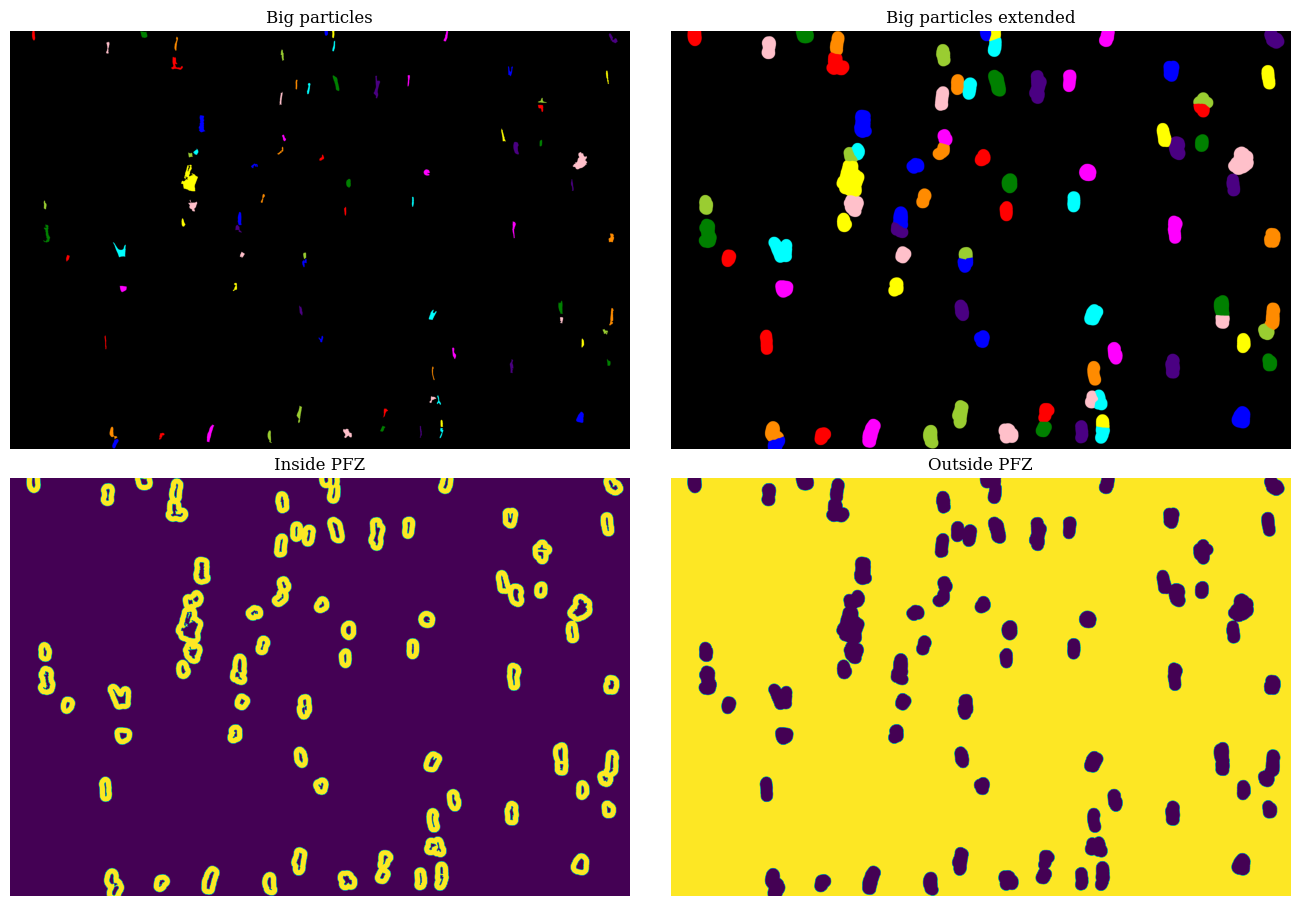

In [19]:
if to_plot:
    ratio_wh = mask.shape[1] / mask.shape[0]
    i = 9
    figsize = (i * ratio_wh, i)

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize)
    ax0, ax1, ax2, ax3 = axes.ravel()
    ax0.imshow(skc.label2rgb(mreg_big.label_map))
    ax1.imshow(skc.label2rgb(seg2))
    ax2.imshow(pfz)
    ax3.imshow(not_pfz)
    for ax, title in zip(
        axes.ravel(),
        ["Big particles", "Big particles extended", "Inside PFZ", "Outside PFZ"]
    ):
        ax.axis("off")
        ax.set_title(title)
    fig.tight_layout(pad=0.5)
    fig.savefig(
        dir_data / f"pfz_threshold{constituent_threshold:.2f}_pfz{pfz_extent:.2f}.png",
        bbox_inches="tight",
        pad_inches=0,
        dpi=300
    )

Get labels of constituent particles, dispersoids inside PFZs and dispersoids outside
PFZs

In [20]:
# Constituent particles
labels_big = mreg.label[mask_big]

# All particles inside PFZs (regardless of size), excluding constituent particles
labels_inside_all = mreg.label_map[pfz]
labels_inside = np.unique(labels_inside_all)[1:]

# Outside PFZs
mask_outside_all = ~np.isin(mreg.label, np.concatenate([labels_big, labels_inside]))
labels_outside = mreg.label[mask_outside_all]

Sanity check (raises assertion error if false)

In [21]:
assert np.allclose(mreg.label, np.sort(np.concatenate([labels_big, labels_inside, labels_outside])))

Density and size of dispersoids inside PFZ

In [22]:
r_all = 0.816 * 2 * mreg.equivalent_radius
mask_dispersoid_all = (r_all >= dispersoid_threshold_min) & (r_all <= dispersoid_threshold_max)

mask_inside_all = np.isin(mreg.label, labels_inside)
mreg_inside = mreg[mask_inside_all & mask_dispersoid_all]

n_inside = mreg_inside.label.size
size_inside = 0.816 * 2 * mreg_inside.equivalent_radius
area_inside = mreg_inside.area

# Statistics
density_inside = n_inside / area_pfz
size_inside_mean = np.average(size_inside, weights=area_inside)

print(f"{density_inside:.2f}, {size_inside_mean:.2f}")

1.16, 0.09


Density and size of dispersoids outside PFZ

In [23]:
mreg_outside = mreg[mask_outside_all & mask_dispersoid_all]

n_outside = mreg_outside.label.size
size_outside = 0.816 * 2 * mreg_outside.equivalent_radius
area_outside = mreg_outside.area

# Statistics
density_outside = n_outside / area_not_pfz
size_outside_mean = np.average(size_outside, weights=area_outside)

print(f"{density_outside:.2f}, {size_outside_mean:.2f}")

1.21, 0.07


Concatenate data and save to one file

In [24]:
columns = ["r", "area", "is_constituent", "is_dispersoid", "inside_pfz"]
particles = pd.DataFrame(
    np.zeros((mreg.label.size, len(columns))),
    columns=columns,
)

In [25]:
particles.loc[mask_big, "is_constituent"] = 1
particles.loc[mask_dispersoid_all, "is_dispersoid"] = 1
particles.loc[mask_inside_all, "inside_pfz"] = 1

particles["r"] = mreg.equivalent_radius
particles["area"] = mreg.area

Sanity check

In [26]:
assert np.allclose(
    np.sum(particles["inside_pfz"].astype(bool) & particles["is_dispersoid"].astype(bool)),
    n_inside
)
assert np.allclose(particles["is_constituent"].sum(), mreg_big.label.size)

Write to file

In [27]:
np.savetxt(
    dir_data / f"pfz_stats_threshold{constituent_threshold:.2f}_pfz{pfz_extent:.2f}.csv",
    particles.values,
    fmt="%.5f,%.5f,%i,%i,%i",
    header=(
        "r,area,is_constituent,is_dispersoid,inside_pfz\n"
        f"area pfz: {area_pfz:.5f} \n"
        f"area not pfz: {area_not_pfz:.5f}"
    )
)

## Densities and sizes per condition

See corresponding *Python* script to run the below procedure from the command line.

In [ ]:
dsets = ["1", "2", "3"]
t_pfz = [0.5, 1, 1.5, 2]
constituent_threshold = [0.7, 0.8, 0.9, 1]

density_inside = np.zeros((len(identifier), len(t_pfz), len(constituent_threshold)))
size_inside_mean = np.zeros_like(density_inside)
density_outside = np.zeros_like(density_inside)
size_outside_mean = np.zeros_like(density_inside)
fv_inside = np.zeros_like(density_inside)
fv_outside = np.zeros_like(density_inside)
nv_inside_mean = np.zeros_like(density_inside)
nv_outside_mean = np.zeros_like(density_inside)
nv_inside_std = np.zeros_like(density_inside)
nv_outside_std = np.zeros_like(density_inside)
ns_inside_mean = np.zeros_like(density_inside)
ns_outside_mean = np.zeros_like(density_inside)
ns_inside_std = np.zeros_like(density_inside)
ns_outside_std = np.zeros_like(density_inside)

for i, sample in enumerate(identifier):
    for j, t_pfz_j in enumerate(t_pfz):
        for k, ct_k in enumerate(constituent_threshold):
            masks_inside = np.zeros((0,), dtype=bool)
            masks_outside = np.zeros((0,), dtype=bool)
            radii = np.zeros((0,))
            areas = np.zeros((0,))
            area_pfz_all = 0
            area_not_pfz_all = 0

            for l, dset in enumerate(dsets):
                dir_data = f"/home/hakon/phd/data/p/prover/{sample}/{dset}/partdet"
                fname = f"pfz_stats_threshold{ct_k:.2f}_pfz{t_pfz_j:.2f}.csv"
                
                # Read total areas inside PFZ and outside PFZ
                with open(dir_data + "/" + fname, mode="r") as f:
                    header = f.readlines()[1:3]
                area_pfz_all += float(re.search("\d+.\d+", header[0]).group())
                area_not_pfz_all += float(re.search("\d+.\d+", header[1]).group())
                
                # Read particle data
                (
                    r, area, is_const, is_disp, inside_pfz
                ) = np.loadtxt(dir_data + "/" + fname, delimiter=",", skiprows=2, unpack=True)
                is_const = is_const.astype(bool)
                is_disp = is_disp.astype(bool)
                inside_pfz = inside_pfz.astype(bool)
                
                # Create masks
                mask_inside = np.logical_and.reduce((inside_pfz, is_disp, ~is_const))
                mask_outside = np.logical_and.reduce((~inside_pfz, is_disp, ~is_const))
                
                # Append
                masks_inside = np.append(masks_inside, mask_inside)
                masks_outside = np.append(masks_outside, mask_outside)
                radii = np.append(radii, r)
                areas = np.append(areas, area)
                
            # Calculate statistics
            radii_inside = radii[masks_inside]
            radii_outside = radii[masks_outside]
            area_inside = areas[masks_inside]
            area_outside = areas[masks_outside]
            density_inside[i, j, k] = np.sum(masks_inside) / area_pfz_all
            density_outside[i, j, k] = np.sum(masks_outside) / area_not_pfz_all
            size_inside_mean[i, j, k] = np.average(radii_inside, weights=area_inside)
            size_outside_mean[i, j, k] = np.average(radii_outside, weights=area_outside)
            
            fv_inside[i, j, k] = np.sum(area_inside) / area_pfz_all
            fv_outside[i, j, k] = np.sum(area_outside) / area_not_pfz_all
            nv_in = 3 * fv_inside[i, j, k] / (4 * np.pi * radii_inside ** 3)
            nv_out = 3 * fv_outside[i, j, k] / (4 * np.pi * radii_outside ** 3)
            ns_in = 2 * radii_inside * nv_in
            ns_out = 2 * radii_outside * nv_out
            nv_inside_mean[i, j, k] = nv_in.mean()
            nv_outside_mean[i, j, k] = nv_out.mean()
            nv_inside_std[i, j, k] = nv_in.std()
            nv_outside_std[i, j, k] = nv_out.std()
            ns_inside_mean[i, j, k] = ns_in.mean()
            ns_outside_mean[i, j, k] = ns_out.mean()
            ns_inside_std[i, j, k] = ns_in.std()
            ns_outside_std[i, j, k] = ns_out.std()

Plot of parameter search

In [ ]:
i = 3
x_ticks = np.arange(len(constituent_threshold))
y_ticks = np.arange(len(t_pfz))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 10 / 2.6))
im0 = ax0.imshow(ns_inside_mean[i] / ns_outside_mean[i])
im1 = ax1.imshow(size_inside_mean[i] / size_outside_mean[i])

# Colorbars
fig.colorbar(im0, ax=ax0, label="Relative dispersoid density $N_{\mathrm{S,PFZ}} / N_{\mathrm{S}}$")
fig.colorbar(im1, ax=ax1, label="Relative dispersoid size $d_{\mathrm{A,PFZ}} / d_{\mathrm{A}}$")

# Ticks and annotations
for ax in (ax0, ax1):
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(constituent_threshold)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(t_pfz)
    ax.set_xlabel(r"Min. constituent particle size $d$ [$\mu$m]")
    ax.set_ylabel(r"PFZ thickness [$\mu$m]")
    # Rectangle
    rect_vert = mpatches.Rectangle(
        xy=(x_ticks[1] - 0.5, y_ticks[0] - 0.5),
        width=1,
        height=y_ticks.size,
        ec="r",
        fc="none",
        zorder=10,
        clip_on=False,
        linewidth=2
    )
    ax.add_patch(rect_vert)

# Print values inside tiles
for y in y_ticks:
    for x in x_ticks:
        ax0.text(x, y, f"{ns_inside_mean[i, y, x] / ns_outside_mean[i, y, x]:.2f}", va="center", ha="center", c="r")
        ax1.text(x, y, f"{size_inside_mean[i, y, x] / size_outside_mean[i, y, x]:.2f}", va="center", ha="center", c="r")
fig.tight_layout()
#fig.savefig(
#    f"/home/hakon/phd/data/p/prover/{identifier[i]}/pfz_param_search.png",
#    bbox_inches="tight",
#    pad_inches=0,
#    dpi=150
#)

Plots as a function of distance from the particle

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))
for i, title in enumerate(titles):
    ax0.plot(x_ticks, ns_inside_mean[i, :, 1] / ns_outside_mean[i, :, 1], "-o", label=title)
    ax1.plot(x_ticks, size_inside_mean[i, :, 1] / size_outside_mean[i, :, 1], "-o")
# Ticks
ax0.set_xticks(x_ticks)
ax0.set_xticklabels(t_pfz)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(t_pfz)
# Labels
ax0.set_xlabel("Distance from constituent particles [$\mu$m]")
ax0.set_ylabel("Relative dispersoid density $N_{\mathrm{S,PFZ}} / N_{\mathrm{S}}$")
ax1.set_xlabel("Distance from constituent particles [$\mu$m]")
ax1.set_ylabel("Relative dispersoid size $d_{\mathrm{A,PFZ}} / d_{\mathrm{A}}$")
# Horizontal line at 1
xlim = ax0.get_xlim()
ax0.plot([x_ticks[0] - 1, x_ticks[-1] + 1], [1, 1], "--", color="gray", zorder=0)
ax0.set_xlim(*xlim)
ax0.legend()
fig.tight_layout()
#fig.savefig("/home/hakon/phd/data/p/prover/pfz_distance.png", bbox_inches="tight", pad_inches=0, dpi=300)